<a href="https://colab.research.google.com/github/OumGhaith/Comparative_Steel_Inspection_using_Densnet_and_k_cross_validation/blob/main/DenseNet_Steel_Inspection_K_cross_Validation_Comparative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Transform
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# Load datasets
train_dataset = ImageFolder('/content/drive/MyDrive/steel_images/train_dataset', transform=transform)
test_dataset  = ImageFolder('/content/drive/MyDrive/steel_images/test_dataset', transform=transform)

all_dataset = train_dataset + test_dataset
all_labels = np.array([label for _, label in all_dataset])
print(f"Total images: {len(all_dataset)}, Classes: {train_dataset.classes}")


Using device: cuda
Total images: 1800, Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [14]:
# Set up K-Fold and track last fold
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_results = []
final_model = None
final_val_subset = None
final_val_loader = None


In [15]:
# Train and evaluate per fold
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(all_labels)), all_labels)):
    print(f"\n=== Fold {fold+1}/{k_folds} ===")

    train_subset = Subset(all_dataset, train_idx)
    val_subset   = Subset(all_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_subset, batch_size=16, shuffle=False)

    # Load DenseNet121
    model = models.densenet121(pretrained=True)
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, len(train_dataset.classes))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train (shorter for demo)
    epochs = 10
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss/len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss/len(val_loader))

    # Evaluate
    model.eval()
    all_true, all_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_true.extend(labels.cpu().numpy())
            all_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(all_true, all_pred) * 100
    print(f"Fold {fold+1} Accuracy: {acc:.2f}%")
    fold_results.append(acc)

    # Save last fold for inspection
    if fold == k_folds - 1:
        final_model = model
        final_val_subset = val_subset
        final_val_loader = val_loader
        final_train_losses, final_val_losses = train_losses, val_losses



=== Fold 1/5 ===


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 118MB/s]


Fold 1 Accuracy: 100.00%

=== Fold 2/5 ===


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 2 Accuracy: 99.17%

=== Fold 3/5 ===


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 3 Accuracy: 100.00%

=== Fold 4/5 ===


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 4 Accuracy: 100.00%

=== Fold 5/5 ===


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 5 Accuracy: 100.00%


In [16]:
# Inspect missclassified images
final_model.eval()
wellclassified, misclassified = [], []

with torch.no_grad():
    for img, true_label in final_val_subset:
        img_input = img.unsqueeze(0).to(device)
        outputs = final_model(img_input)
        pred_label = torch.argmax(outputs, dim=1).item()
        if pred_label == true_label:
            wellclassified.append((img.cpu(), true_label, pred_label))
        else:
            misclassified.append((img.cpu(), true_label, pred_label))

print(f"Well-classified: {len(wellclassified)}, Misclassified: {len(misclassified)}")


Well-classified: 360, Misclassified: 0


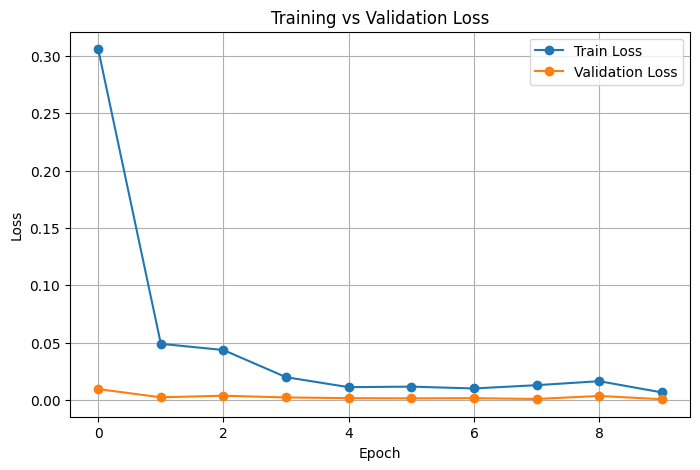

In [17]:
# Plot Loss curves
plt.figure(figsize=(8,5))
plt.plot(final_train_losses, label="Train Loss", marker='o')
plt.plot(final_val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


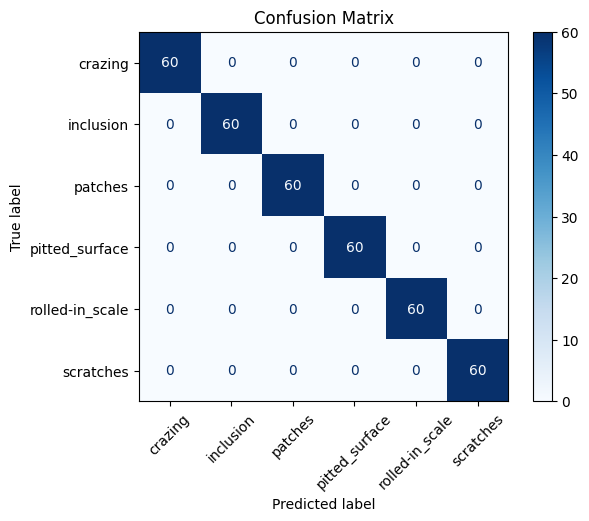

In [18]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

all_true = [t for _, t, _ in wellclassified + misclassified]
all_pred = [p for _, _, p in wellclassified + misclassified]

cm = confusion_matrix(all_true, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


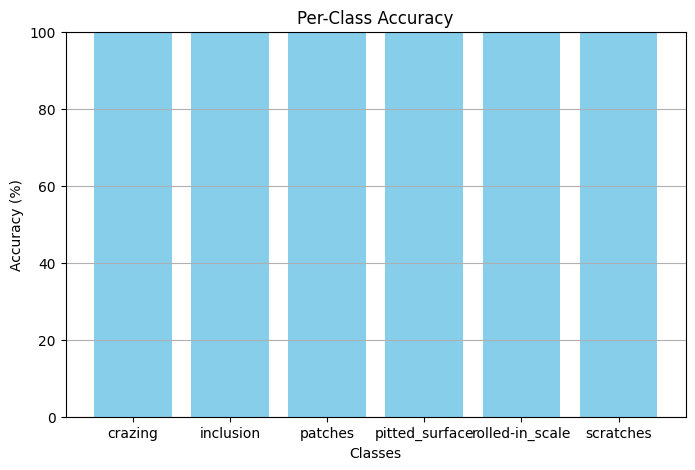

Class crazing: 100.00%
Class inclusion: 100.00%
Class patches: 100.00%
Class pitted_surface: 100.00%
Class rolled-in_scale: 100.00%
Class scratches: 100.00%


In [19]:
# Plot Accuracy per class
classes = train_dataset.classes
class_correct = np.zeros(len(classes))
class_total = np.zeros(len(classes))

for _, true, pred in wellclassified + misclassified:
    class_total[true] += 1
    if true == pred:
        class_correct[true] += 1

class_acc = class_correct / class_total * 100

plt.figure(figsize=(8,5))
plt.bar(classes, class_acc, color='skyblue')
plt.ylabel("Accuracy (%)")
plt.xlabel("Classes")
plt.title("Per-Class Accuracy")
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()

for cls, acc in zip(classes, class_acc):
    print(f"Class {cls}: {acc:.2f}%")


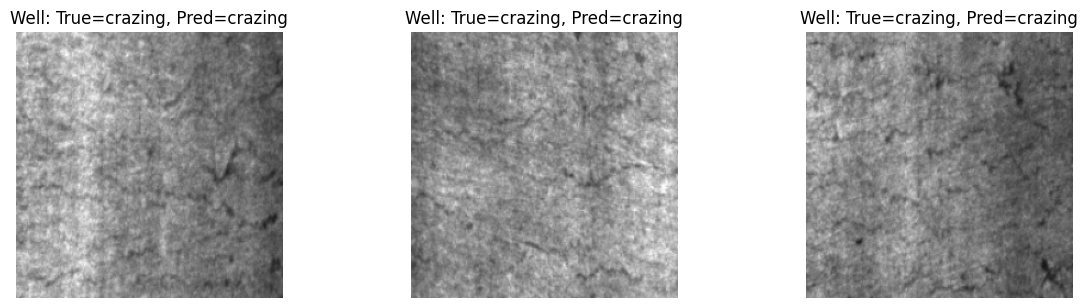

In [20]:
# Visualize Well & Misclassified Images
import matplotlib.pyplot as plt

# Display top 3 well-classified
fig = plt.figure(figsize=(12, 6))
for i in range(min(3, len(wellclassified))):
    img, true, pred = wellclassified[i]
    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    ax.set_title(f"Well: True={train_dataset.classes[true]}, Pred={train_dataset.classes[pred]}")
    ax.axis('off')

# Display top 3 misclassified
for i in range(min(3, len(misclassified))):
    img, true, pred = misclassified[i]
    ax = fig.add_subplot(2, 3, i + 4)
    ax.imshow(img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    ax.set_title(f"Mis: True={train_dataset.classes[true]}, Pred={train_dataset.classes[pred]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


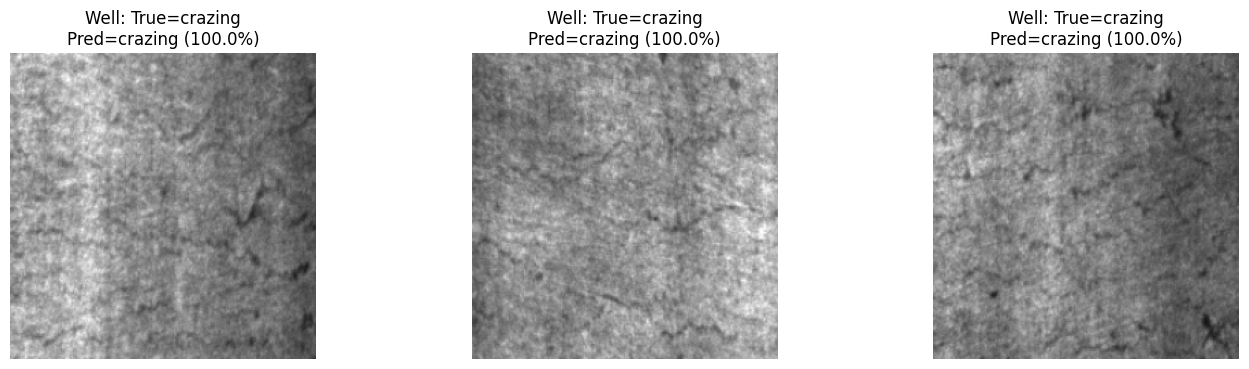

In [21]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Collect probabilities for well & misclassified
wellclassified_probs = [(img, t, pred, F.softmax(model(img.unsqueeze(0).to(device)), dim=1).max().item())
                        for img, t, pred in wellclassified]

misclassified_probs = [(img, t, pred, F.softmax(model(img.unsqueeze(0).to(device)), dim=1).max().item())
                       for img, t, pred in misclassified]

# Plot
fig = plt.figure(figsize=(14, 7))

# Well-classified top 3
for i in range(min(3, len(wellclassified_probs))):
    img, true, pred, prob = wellclassified_probs[i]
    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    ax.set_title(f"Well: True={train_dataset.classes[true]}\nPred={train_dataset.classes[pred]} ({prob*100:.1f}%)")
    ax.axis('off')

# Misclassified top 3
for i in range(min(3, len(misclassified_probs))):
    img, true, pred, prob = misclassified_probs[i]
    ax = fig.add_subplot(2, 3, i + 4)
    ax.imshow(img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    ax.set_title(f"Mis: True={train_dataset.classes[true]}\nPred={train_dataset.classes[pred]} ({prob*100:.1f}%)")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [22]:
# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/steel_images/densenet121_final.pt')


In [23]:
# Save the indices of your train/val splits (for reproducibility)
import pickle

with open('/content/drive/MyDrive/steel_images/train_idx.pkl', 'wb') as f:
    pickle.dump(train_idx, f)
with open('/content/drive/MyDrive/steel_images/val_idx.pkl', 'wb') as f:
    pickle.dump(val_idx, f)


In [24]:
# Save misclassified/well-classified lists
with open('/content/drive/MyDrive/steel_images/misclassified.pkl', 'wb') as f:
    pickle.dump(misclassified, f)
with open('/content/drive/MyDrive/steel_images/wellclassified.pkl', 'wb') as f:
    pickle.dump(wellclassified, f)


In [25]:
plt.savefig('/content/drive/MyDrive/steel_images/loss_curve.png')


<Figure size 640x480 with 0 Axes>

In [26]:
# Total & Trainable Parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Total parameters: 6960006
Trainable parameters: 6960006


In [27]:
# Model Size on Disk (Memory footprint)
model_path = '/content/drive/MyDrive/steel_images/densenet121_final.pt'
torch.save(model.state_dict(), model_path)  # save first
model_size_mb = os.path.getsize(model_path) / 1e6
print(f"Model size: {model_size_mb:.2f} MB")


Model size: 28.45 MB


In [28]:
# Average Inference Time per Image
import time

model.eval()
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Warm-up (especially important on GPU)
for _ in range(10):
    _ = model(dummy_input)

# Timing
start_time = time.time()
for _ in range(100):  # run multiple times for average
    _ = model(dummy_input)
inference_time = (time.time() - start_time) / 100 * 1000  # ms per image
print(f"Average inference time: {inference_time:.2f} ms per image")


Average inference time: 17.89 ms per image


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 2 — Well-classified: 358, Misclassified: 2


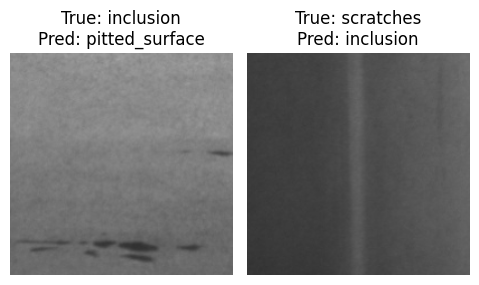

In [29]:
# =============================
# 1️⃣ Run Fold 2 Only for Inspection
# =============================
from torch.utils.data import Subset, DataLoader

# Get train and validation indices for fold 2 (index 1, because Python is 0-based)
train_idx, val_idx = list(skf.split(np.zeros(len(all_labels)), all_labels))[1]

# Create subsets
train_subset = Subset(all_dataset, train_idx)
val_subset   = Subset(all_dataset, val_idx)

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=16, shuffle=False)

# =============================
# 2️⃣ Load DenseNet121 (same as before)
# =============================
model = models.densenet121(pretrained=True)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, len(train_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# =============================
# 3️⃣ Train for this fold
# =============================
epochs = 10
for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# =============================
# 4️⃣ Collect Misclassified & Well-Classified Images
# =============================
model.eval()
wellclassified, misclassified = [], []

with torch.no_grad():
    for img, label in val_subset:
        img_gpu = img.unsqueeze(0).to(device)
        output = model(img_gpu)
        pred = torch.argmax(output, dim=1).item()
        if pred == label:
            wellclassified.append((img, label, pred))
        else:
            misclassified.append((img, label, pred))

print(f"Fold 2 — Well-classified: {len(wellclassified)}, Misclassified: {len(misclassified)}")

# =============================
# 5️⃣ Plot a Few Misclassified Images
# =============================
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))
for i in range(min(5, len(misclassified))):  # show up to 5 misclassified
    img, t, p = misclassified[i]
    ax = fig.add_subplot(1,5,i+1)
    ax.imshow(img.permute(1,2,0).cpu().numpy()*0.5 + 0.5)
    ax.set_title(f"True: {train_dataset.classes[t]}\nPred: {train_dataset.classes[p]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [30]:
# =============================
# Save Fold 2 Model
# =============================
fold2_model_path = '/content/drive/MyDrive/steel_images/densenet121_fold2.pt'
torch.save(model.state_dict(), fold2_model_path)
print(f"Fold 2 model saved at: {fold2_model_path}")

# =============================
# Later, Reload Fold 2 Model Without Retraining
# =============================
# 1️⃣ Load model architecture
fold2_model = models.densenet121(pretrained=False)
num_features = fold2_model.classifier.in_features
fold2_model.classifier = nn.Linear(num_features, len(train_dataset.classes))
fold2_model = fold2_model.to(device)

# 2️⃣ Load saved weights
fold2_model.load_state_dict(torch.load(fold2_model_path, map_location=device))
fold2_model.eval()
print("Fold 2 model loaded and ready for inference!")


Fold 2 model saved at: /content/drive/MyDrive/steel_images/densenet121_fold2.pt


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fold 2 model loaded and ready for inference!
